# RetinaNet Streamlit - Function Testing

## Data Utilities

Once user has specified an image or uploaded, we need a one-time call to fetch all data artifacts that will be used through the app. Those include:
- Image Option and Image Path
- Viz Artifacts saved as model attribute
 - Backbone Features
 - Head Outputs
 - Anchors
- Post-processed model outputs (dict)
- Feature Map Plot

In [1]:
import sys

In [2]:
from src.model_utils import get_inference_artifacts
from src.app_utils import get_feature_map_plot
from src.data_utils import gather_data_artifacts

%load_ext autoreload
%autoreload 2

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 10.3 µs


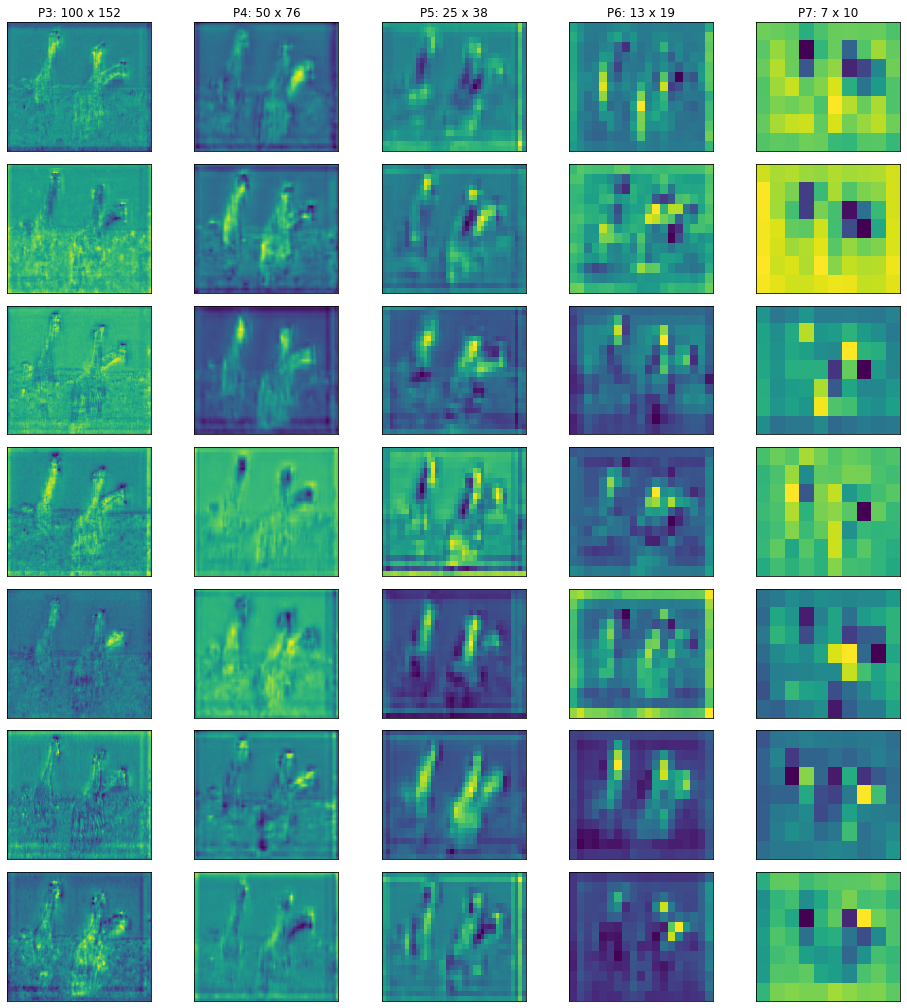

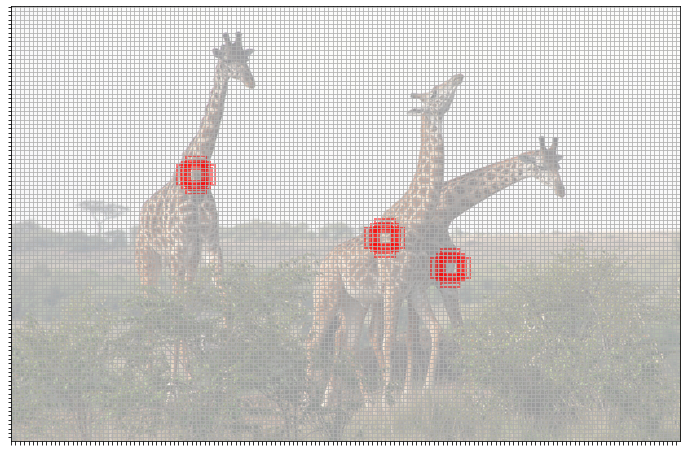

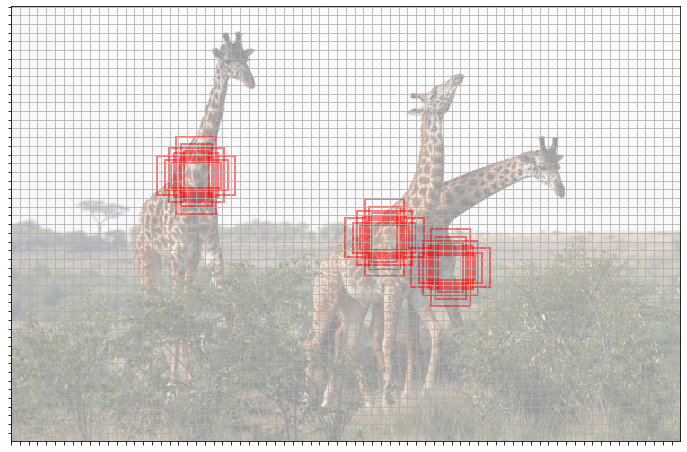

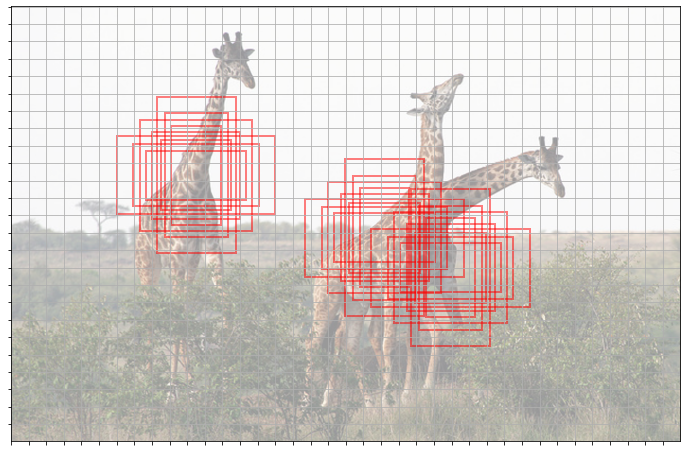

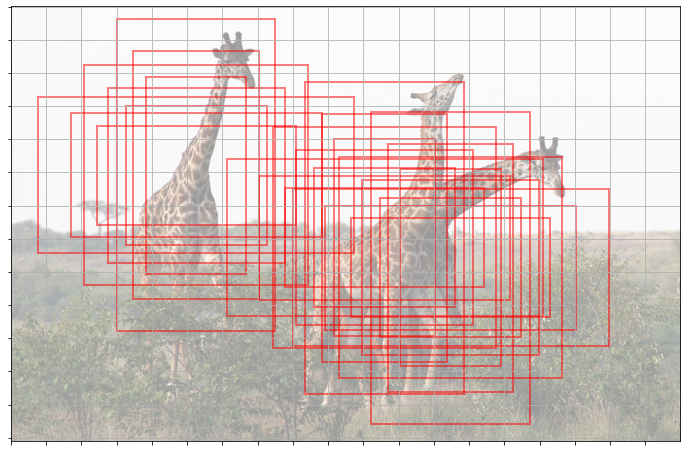

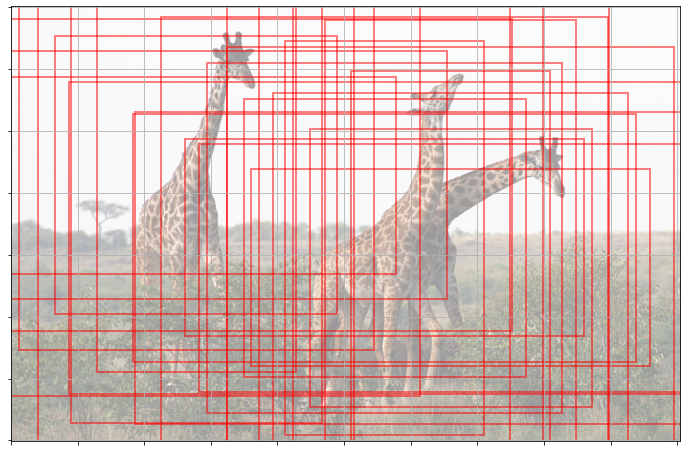

In [3]:
%time

data_artifacts = gather_data_artifacts("images/giraffe.jpg")
# data_artifacts = gather_data_artifacts(fs_test)

## Anchor Generation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from src.anchor_utils import AnchorGenerator

In [5]:
anchor_sizes = tuple(
    (x, int(x * 2 ** (1.0 / 3)), int(x * 2 ** (2.0 / 3)))
    for x in [32, 64, 128, 256, 512]
)
aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)

In [229]:
aspect_ratios

((0.5, 1.0, 2.0),
 (0.5, 1.0, 2.0),
 (0.5, 1.0, 2.0),
 (0.5, 1.0, 2.0),
 (0.5, 1.0, 2.0))

In [228]:
anchor_sizes

((32, 40, 50),
 (64, 80, 101),
 (128, 161, 203),
 (256, 322, 406),
 (512, 645, 812))

In [233]:
anchor_generator.anchor_artifacts['grid_sizes']

[torch.Size([100, 152]),
 torch.Size([50, 76]),
 torch.Size([25, 38]),
 torch.Size([13, 19]),
 torch.Size([7, 10])]

In [6]:
anchors = anchor_generator(data_artifacts['viz_artifacts']['images'], data_artifacts['viz_artifacts']['features'])


In [71]:
image = data_artifacts['image']
grid_sizes = anchor_generator.anchor_artifacts['grid_sizes']
strides = anchor_generator.anchor_artifacts['strides']
cell_anchors = anchor_generator.cell_anchors.copy()
image_size = anchor_generator.anchor_artifacts['image_size']
pred_boxes = data_artifacts['outputs']['boxes']

features = data_artifacts['viz_artifacts']['features']

In [11]:
def convert_bb_spec(xmin, ymin, xmax, ymax):
    """
    Convert a bounding box representation
    
    """

    x = xmin
    y = ymin
    width = xmax - xmin
    height = ymax - ymin

    return x, y, width, height

def plot_pyramid_level_anchors(pyramid_level_idx, img, image_size, strides, cell_anchors, pred_boxes):
    '''
    This function overlays a full set of anchor boxes (all aspect ratios and sizes) on a given image
    centered atop each object detected in the image. Specifiying the pyramid level allows you to
    visualize the size of the anchor boxes relative to the feature map resolution (shown by grid size)
    
    Args:
        pyramide_level_index (int)
        img (PIL.Image.Image)
        image_size (torch.Size)
        strides (List[List[torch.Tensor]])
        cell_anchors (List[torch.Tensor])
        pred_boxes (torch.Tensor)
    
    Returns:
        fig - matplotlib figure
    
    '''

    figsize = [round(i/100) for i in image_size]
    fig, ax = plt.subplots(1, figsize=(figsize[::-1]))
    ax.grid(True)
    ax.set_xticks(np.arange(0, image_size[1], strides[pyramid_level_idx][1]))
    ax.set_yticks(np.arange(0, image_size[0], strides[pyramid_level_idx][0]))
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.imshow(img.resize(image_size[::-1]), aspect='auto', alpha=.4)
    
    box_centers = [((box[2]-box[0])/2 + box[0], (box[3]-box[1])/2 + box[1]) for box in pred_boxes.tolist()]

    for box_center in box_centers:
        for i, box in enumerate(cell_anchors[pyramid_level_idx]):
            x, y, width, height = convert_bb_spec(*box)

            x_offset = box_center[0]
            y_offset = box_center[1]
    
            patch = patches.Rectangle(
                        (x+x_offset, y+y_offset),
                        width,
                        height,
                        alpha=.5,
                        edgecolor="red",
                        linewidth=2,
                        facecolor="none",
                    )
            ax.add_patch(patch)
        
    return fig

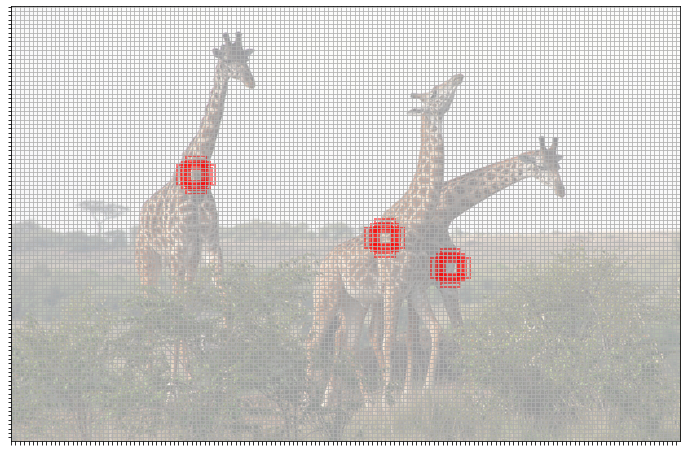

In [12]:
b = plot_pyramid_level_anchors(0, image, image_size, strides, cell_anchors, pred_boxes)

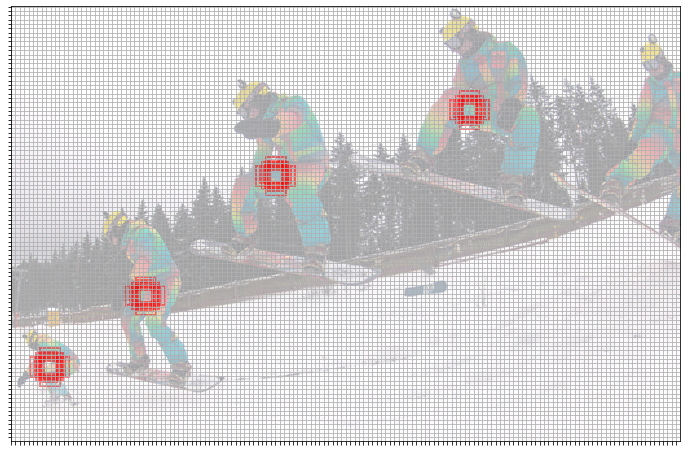

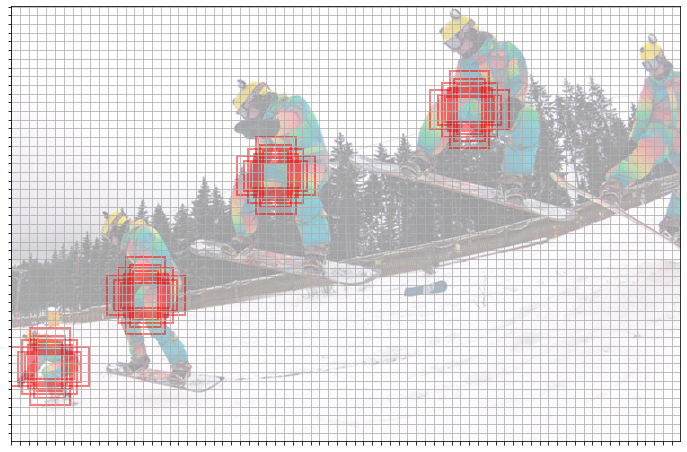

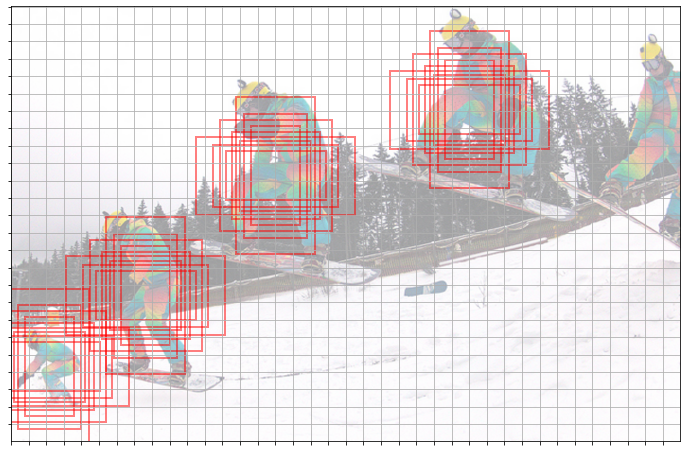

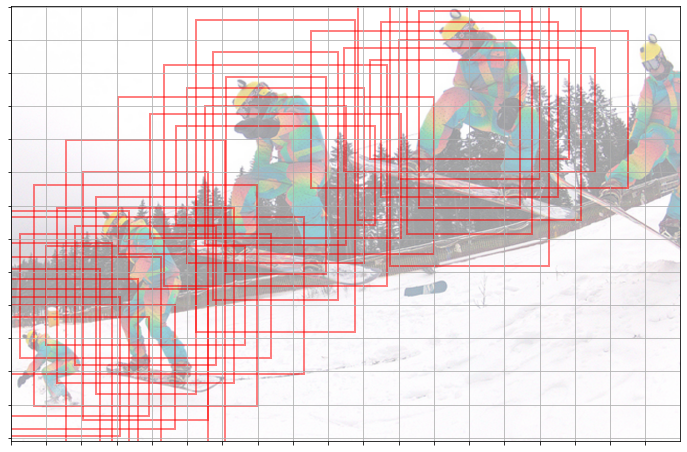

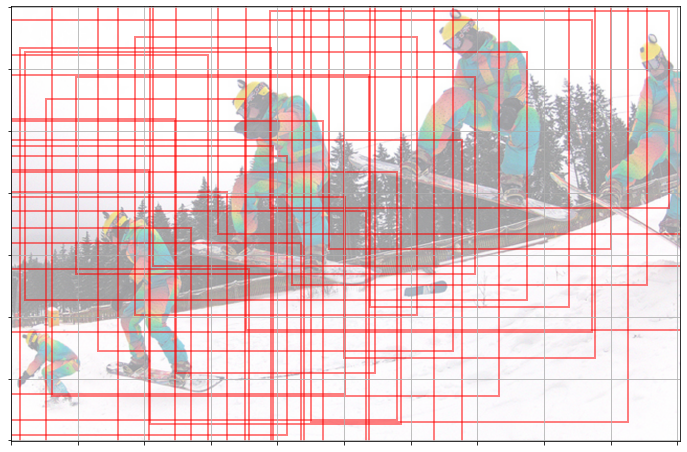

In [11]:
for i in range(5):
    plot_pyramid_level_anchors(i, image, image_size, strides, cell_anchors, pred_boxes)

### Plot feature maps

In [222]:
def plot_pyramid_level_anchors2(pyramid_level_idx, img, image_size, strides, cell_anchors, pred_boxes, features):
    '''
    This function overlays a full set of anchor boxes (all aspect ratios and sizes) on a given image
    centered atop each object detected in the image. Specifiying the pyramid level allows you to
    visualize the size of the anchor boxes relative to the feature map resolution (shown by grid size)
    
    Args:
        pyramide_level_index (int)
        img (PIL.Image.Image)
        image_size (torch.Size)
        strides (List[List[torch.Tensor]])
        cell_anchors (List[torch.Tensor])
        pred_boxes (torch.Tensor)
    
    Returns:
        fig - matplotlib figure
    
    '''

    figsize = [round(i/100) for i in image_size]
    figsize[0] = figsize[0]*2
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(figsize[::-1]))
    ax1.grid(True)
    ax1.set_xticks(np.arange(0, image_size[1], strides[pyramid_level_idx][1]))
    ax1.set_yticks(np.arange(0, image_size[0], strides[pyramid_level_idx][0]))
    ax1.axes.xaxis.set_ticklabels([])
    ax1.axes.yaxis.set_ticklabels([])
    ax1.imshow(img.resize(image_size[::-1]), aspect='auto', alpha=.4)
    
    box_centers = [((box[2]-box[0])/2 + box[0], (box[3]-box[1])/2 + box[1]) for box in pred_boxes.tolist()]

    for box_center in box_centers:
        for i, box in enumerate(cell_anchors[pyramid_level_idx]):
            x, y, width, height = convert_bb_spec(*box)

            x_offset = box_center[0]
            y_offset = box_center[1]
    
            patch = patches.Rectangle(
                        (x+x_offset, y+y_offset),
                        width,
                        height,
                        alpha=.5,
                        edgecolor="red",
                        linewidth=2,
                        facecolor="none",
                    )
            ax1.add_patch(patch)
    
    fm = features[pyramid_level_idx][:,66,:,:].detach().numpy()
    fm = np.rollaxis(fm, 0, 3)
    fm_norm = ((fm - fm.min()) * (1/(fm.max() - fm.min()) * 255)).astype('uint8').squeeze(2)
    fm_img = Image.fromarray(fm_norm).resize(image_size[::-1])
    ax2.grid(True)
    ax2.set_xticks(np.arange(0, image_size[1], strides[pyramid_level_idx][1]))
    ax2.set_yticks(np.arange(0, image_size[0], strides[pyramid_level_idx][0]))
    ax2.axes.xaxis.set_ticklabels([])
    ax2.axes.yaxis.set_ticklabels([])
    
    ax2.imshow(fm_img, aspect='auto',)
    
    plt.tight_layout()
        
    return fig

In [226]:
type(features)

list

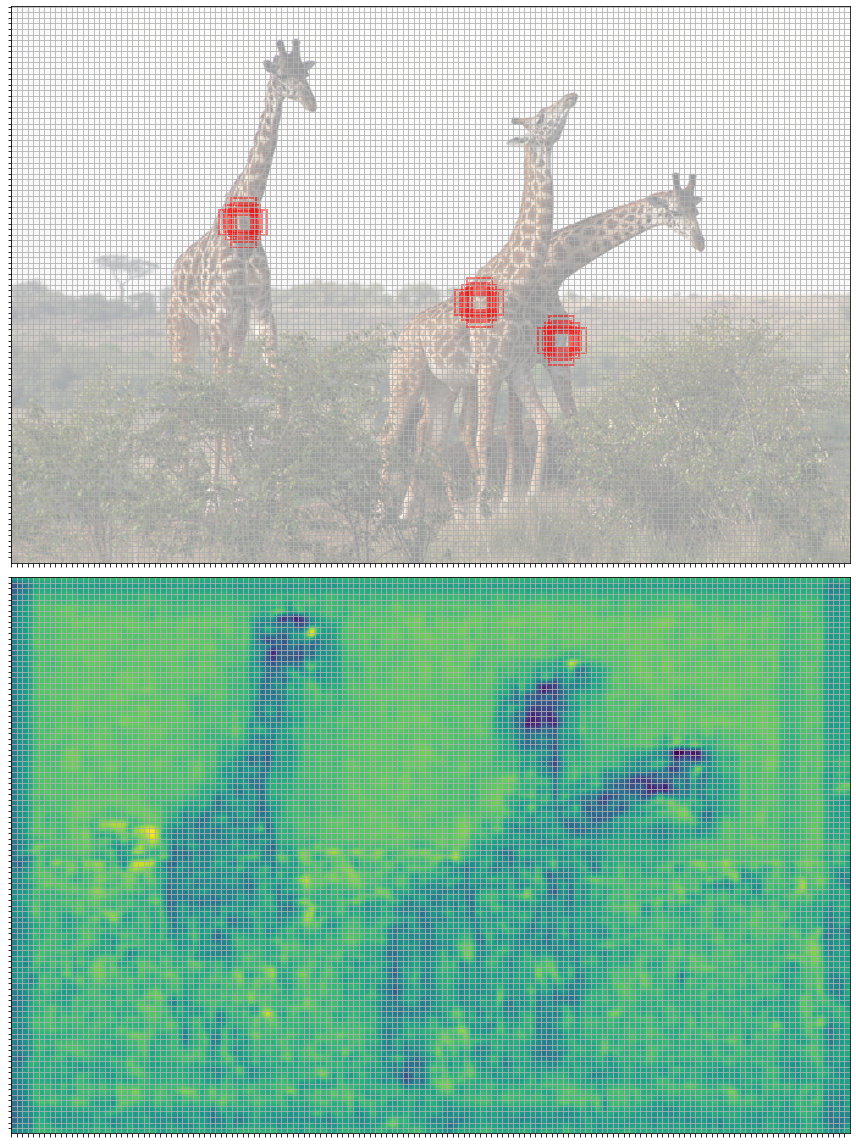

In [227]:
a = plot_pyramid_level_anchors2(0, image, image_size, strides, cell_anchors, pred_boxes, features)

In [239]:
def plot_pyramid_level_anchors3(pyramid_level_idx, img, image_size, strides, cell_anchors, pred_boxes, features):
    '''
    This function overlays a full set of anchor boxes (all aspect ratios and sizes) on a given image
    centered atop each object detected in the image. Specifiying the pyramid level allows you to
    visualize the size of the anchor boxes relative to the feature map resolution (shown by grid size)
    
    Args:
        pyramide_level_index (int)
        img (PIL.Image.Image)
        image_size (torch.Size)
        strides (List[List[torch.Tensor]])
        cell_anchors (List[torch.Tensor])
        pred_boxes (torch.Tensor)
    
    Returns:
        fig - matplotlib figure
    
    '''

    figsize = [round(i/100) for i in image_size]
    figsize[0] = figsize[0]*2
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(figsize[::-1]))
    ax1.grid(True)
    ax1.set_xticks(np.arange(0, image_size[1], strides[pyramid_level_idx][1]))
    ax1.set_yticks(np.arange(0, image_size[0], strides[pyramid_level_idx][0]))
    ax1.axes.xaxis.set_ticklabels([])
    ax1.axes.yaxis.set_ticklabels([])
    ax1.imshow(img.resize(image_size[::-1]), aspect='auto', alpha=.4)
    
    box_centers = [((box[2]-box[0])/2 + box[0], (box[3]-box[1])/2 + box[1]) for box in pred_boxes.tolist()]

    for box_center in box_centers:
        for i, box in enumerate(cell_anchors[pyramid_level_idx]):
            x, y, width, height = convert_bb_spec(*box)

            x_offset = box_center[0]
            y_offset = box_center[1]
    
            patch = patches.Rectangle(
                        (x+x_offset, y+y_offset),
                        width,
                        height,
                        alpha=.5,
                        edgecolor="red",
                        linewidth=2,
                        facecolor="none",
                    )
            ax1.add_patch(patch)
    
    fm = features[pyramid_level_idx][:,66,:,:].detach().numpy()
    fm = np.rollaxis(fm, 0, 3)
    fm_norm = ((fm - fm.min()) * (1/(fm.max() - fm.min()) * 255)).astype('uint8').squeeze(2)
    fm_img = Image.fromarray(fm_norm).resize(image_size[::-1])
    
#     ax2.grid(True)
#     ax2.set_xticks(np.arange(0, image_size[1], strides[pyramid_level_idx][1]))
#     ax2.set_yticks(np.arange(0, image_size[0], strides[pyramid_level_idx][0]))
#     ax2.axes.xaxis.set_ticklabels([])
#     ax2.axes.yaxis.set_ticklabels([])
    
    ax1.imshow(fm_img, aspect='auto', alpha=.6)
    
    plt.tight_layout()
        
    return fig

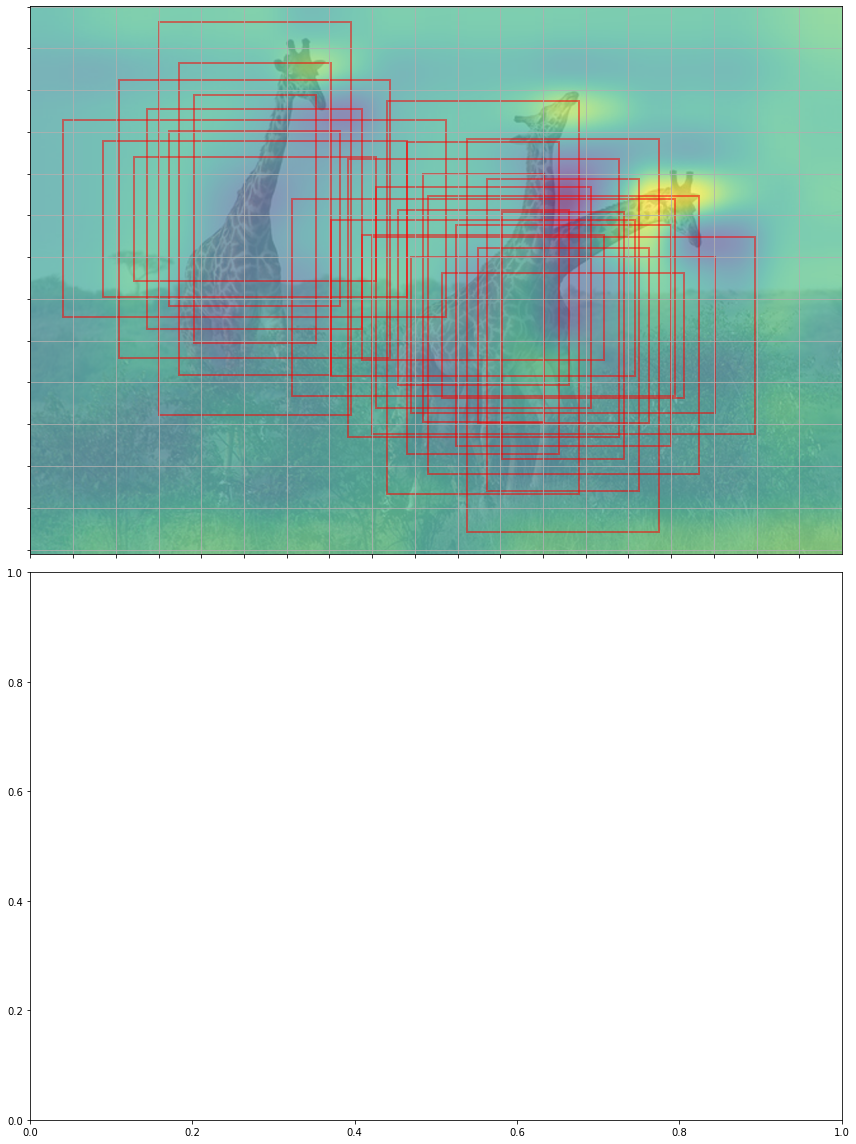

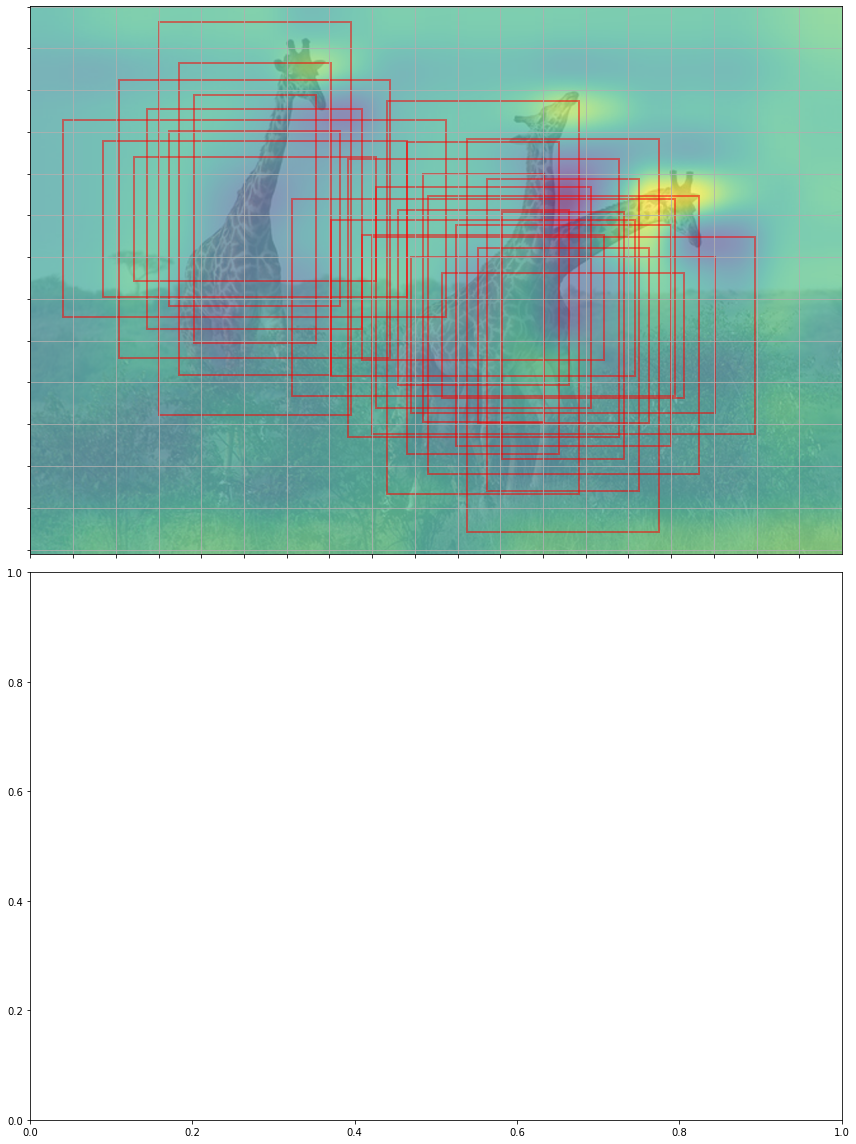

In [242]:
plot_pyramid_level_anchors3(3, image, image_size, strides, cell_anchors, pred_boxes, features)

In [221]:
[round(i/100) for i in image_size]

[8, 12]

In [76]:
features[0][:,66,:,:].squeeze(0).detach().numpy().shape

(100, 152)

In [19]:
data_artifacts['viz_artifacts']['features'][0].shape

torch.Size([1, 256, 100, 152])

In [206]:
fm = data_artifacts['viz_artifacts']['features'][0][:,66,:,:].detach().numpy()
fm = np.rollaxis(fm, 0,3)

In [207]:
fm_norm = ((fm - fm.min()) * (1/(fm.max() - fm.min()) * 255)).astype('uint8')
fm_norm = fm_norm.squeeze(2)
fm_img = Image.fromarray(fm_norm).resize(image_size[::-1])


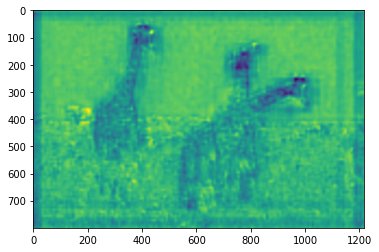

In [208]:
plt.imshow(fm_img)

In [197]:
fm_img = Image.fromarray(fm_norm)

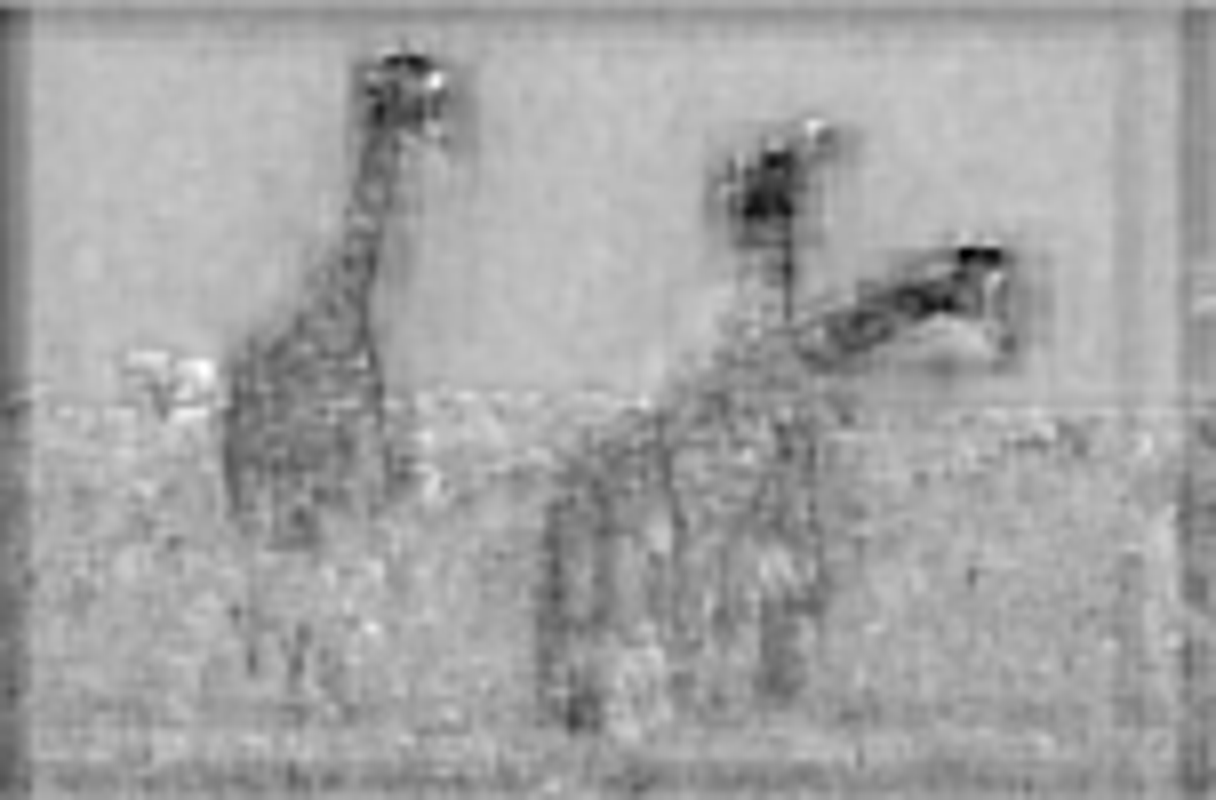

In [198]:
fm_img.resize(image_size[::-1])

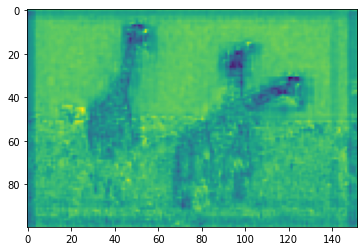

In [195]:
plt.imshow(fm)

In [108]:
# from torchvision import transforms

In [116]:
transform = transforms.Compose([
    transforms.ToPILImage(),
#     transforms.Resize((512, 512)),
#     transforms.ToTensor(),
])

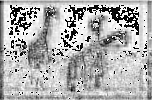

In [117]:
transform(fm)

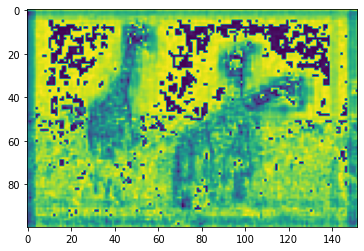

In [121]:
plt.imshow(transform(fm))

In [105]:
fm.shape

torch.Size([1, 100, 152])

In [99]:
from PIL import Image

In [100]:
fm.shape

(1, 100, 152)

In [102]:
Image.fromarray(fm.astype('uint8'))

TypeError: Cannot handle this data type: (1, 1, 152), |u1

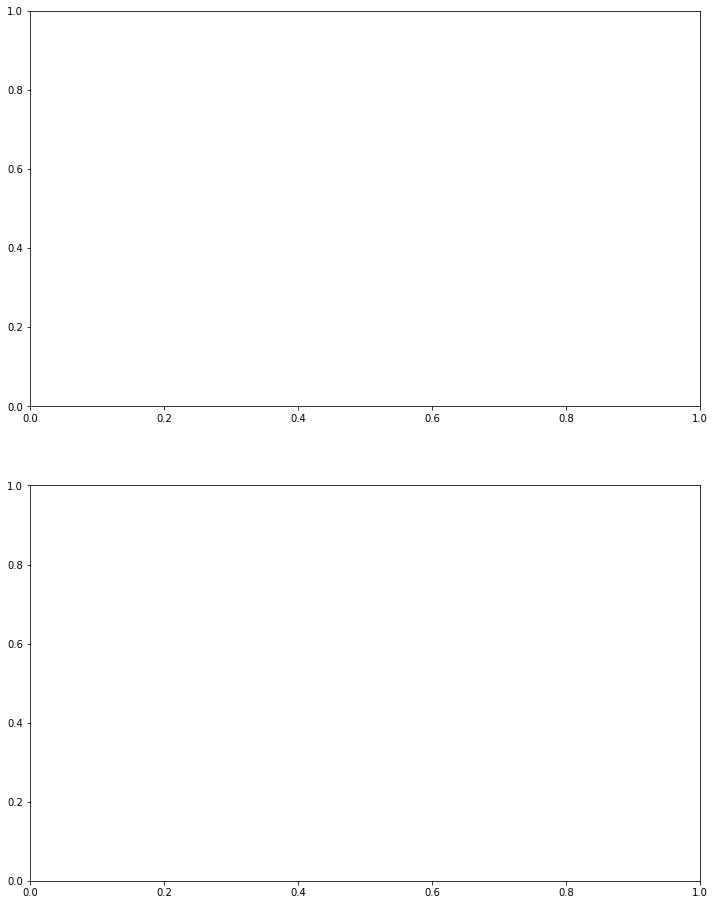

In [61]:
fig, ax = plt.subplots(nrows=2, ncols=1 ,figsize=(12,16))

In [145]:
ax.imshow(fm)

AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

In [48]:
fig.axes[0].yaxis

## Plot Predictions 

In [621]:
from src.app_utils import plot_predictions
from src.model_utils import COCO_LABELS

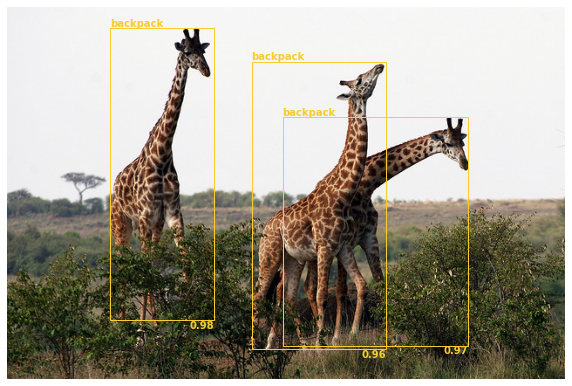

In [622]:
plot_predictions(image=image, outputs=data_artifacts['outputs'], label_map=COCO_LABELS)